In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier)

from catboost import CatBoostClassifier, Pool
import xgboost

from utils import AnalyzingModelPerformance, encoder_y
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight,compute_class_weight

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

In [2]:
data = pd.read_csv('../clean_data.csv').drop(['Unnamed: 0','Type_of_Loan', 'Month'], axis='columns')

In [3]:
data

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month,Age,Annual_Income,...,Payment_Behaviour,Credit_Score,Payday Loan,Personal Loan,Mortgage Loan,Student Loan,Auto Loan,Credit-Builder Loan,Home Equity Loan,Debt Consolidation Loan
0,1824.843333,3.0,4.0,3.0,3.0,4.0,26.822620,49.574949,23.0,19114.12,...,High_spent_Small_value_payments,Good,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
1,1824.843333,3.0,4.0,3.0,3.0,4.0,31.944960,49.574949,23.0,19114.12,...,Low_spent_Large_value_payments,Good,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
2,1824.843333,3.0,4.0,3.0,3.0,4.0,28.609352,49.574949,23.0,19114.12,...,Low_spent_Medium_value_payments,Good,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
3,1824.843333,3.0,4.0,3.0,5.0,4.0,31.377862,49.574949,23.0,19114.12,...,Low_spent_Small_value_payments,Good,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4,1824.843333,3.0,4.0,3.0,6.0,4.0,24.797347,49.574949,23.0,19114.12,...,High_spent_Medium_value_payments,Good,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74095,3359.415833,4.0,6.0,7.0,20.0,3.0,39.323569,35.104023,25.0,39628.99,...,High_spent_Medium_value_payments,Poor,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
74096,3359.415833,4.0,6.0,7.0,23.0,3.0,34.663572,35.104023,25.0,39628.99,...,High_spent_Large_value_payments,Poor,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
74097,3359.415833,4.0,6.0,7.0,18.0,3.0,40.565631,35.104023,25.0,39628.99,...,High_spent_Medium_value_payments,Poor,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
74098,3359.415833,4.0,6.0,7.0,27.0,3.0,41.255522,35.104023,25.0,39628.99,...,High_spent_Large_value_payments,Poor,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [4]:
X = data.drop('Credit_Score',axis='columns')
y = data.Credit_Score.apply(lambda x:  encoder_y(x))

In [7]:
X.Payment_Behaviour.unique()

array(['High_spent_Small_value_payments',
       'Low_spent_Large_value_payments',
       'Low_spent_Medium_value_payments',
       'Low_spent_Small_value_payments',
       'High_spent_Medium_value_payments',
       'High_spent_Large_value_payments'], dtype=object)

In [5]:
X.iloc[:,8:]

,Age,Annual_Income,Num_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Outstanding_Debt,Amount_invested_monthly,Monthly_Balance,Occupation,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Payday Loan,Personal Loan,Mortgage Loan,Student Loan,Auto Loan,Credit-Builder Loan,Home Equity Loan,Debt Consolidation Loan
0,23.0,19114.12,4.0,7.00,11.27,809.98,80.415295,312.494089,Scientist,22.0,No,High_spent_Small_value_payments,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
1,23.0,19114.12,4.0,7.00,11.27,809.98,118.280222,284.629162,Scientist,22.0,No,Low_spent_Large_value_payments,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
2,23.0,19114.12,4.0,7.00,8.77,809.98,81.699521,331.209863,Scientist,22.0,No,Low_spent_Medium_value_payments,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
3,23.0,19114.12,4.0,7.25,6.27,809.98,199.458074,223.451310,Scientist,22.0,No,Low_spent_Small_value_payments,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4,23.0,19114.12,4.0,7.50,11.27,809.98,41.420153,341.489231,Scientist,22.0,No,High_spent_Medium_value_payments,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74095,25.0,39628.99,2.0,6.00,9.50,502.38,140.581403,410.256158,Mechanic,31.0,No,High_spent_Medium_value_payments,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
74096,25.0,39628.99,2.0,7.00,11.50,502.38,60.971333,479.866228,Mechanic,31.0,No,High_spent_Large_value_payments,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
74097,25.0,39628.99,2.0,7.00,11.50,502.38,54.185950,496.651610,Mechanic,31.0,No,High_spent_Medium_value_payments,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
74098,25.0,39628.99,2.0,6.00,11.50,502.38,24.028477,516.809083,Mechanic,31.0,No,High_spent_Large_value_payments,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [13]:
num_features = X.select_dtypes(include=[int, float]).columns.to_list()
cat_features = X.select_dtypes(include=['object']).columns.to_list()

What categorical features is greater than 3 unique class?

In [14]:
for c in cat_features:
    print(f'{c}:{len(X[c].unique())}')

Occupation:15
Payment_of_Min_Amount:2
Payment_Behaviour:6


In [15]:
col_prepro = ColumnTransformer([('scaler', StandardScaler(), num_features),
                                ('target encode', TargetEncoder(), ['Occupation','Payment_Behaviour']),
                                ('one hot', OneHotEncoder(sparse_output=False,drop='first'), ['Payment_of_Min_Amount'])]).set_output(transform='pandas')
x_prepo = col_prepro.fit_transform(X,y)

In [17]:
x_train_prep ,x_test_prep, y_train, y_test = train_test_split(x_prepo,y,
                                                              test_size=0.20,
                                                              stratify=y,
                                                              random_state=42)

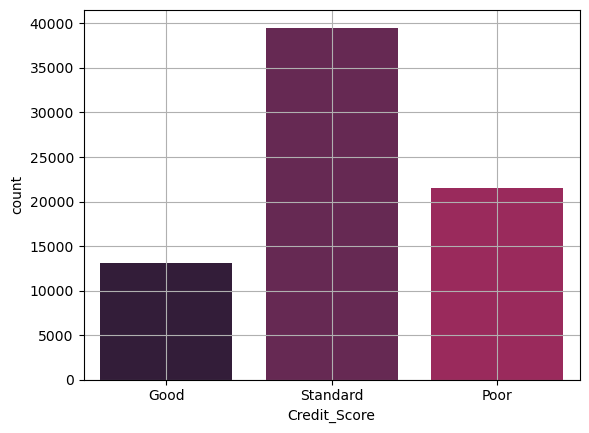

In [19]:
sns.countplot(data=data, x='Credit_Score',
              palette=sns.color_palette("rocket"))
plt.grid()
plt.show()

### Sklearn Models

In [20]:
rnd_forest_unb = RandomForestClassifier()
rnd_forest_unb.fit(x_train_prep, y_train)

ext_tree_unb = ExtraTreesClassifier()
ext_tree_unb.fit(x_train_prep, y_train)

ExtraTreesClassifier()

In [22]:
sk_models = AnalyzingModelPerformance(x_test_prep,
                                      y_test,
                                      models=[rnd_forest_unb,ext_tree_unb],
                                      names=['Random Forest','Extra Trees'])
rnd_report_unb, ext_report_unb= sk_models.models_reports()

In [23]:
print(rnd_report_unb, ext_report_unb)

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      4297
           1       0.79      0.82      0.80      7907
           2       0.75      0.67      0.70      2616

    accuracy                           0.78     14820
   macro avg       0.78      0.76      0.76     14820
weighted avg       0.78      0.78      0.78     14820
               precision    recall  f1-score   support

           0       0.80      0.79      0.79      4297
           1       0.80      0.83      0.81      7907
           2       0.77      0.70      0.74      2616

    accuracy                           0.79     14820
   macro avg       0.79      0.77      0.78     14820
weighted avg       0.79      0.79      0.79     14820



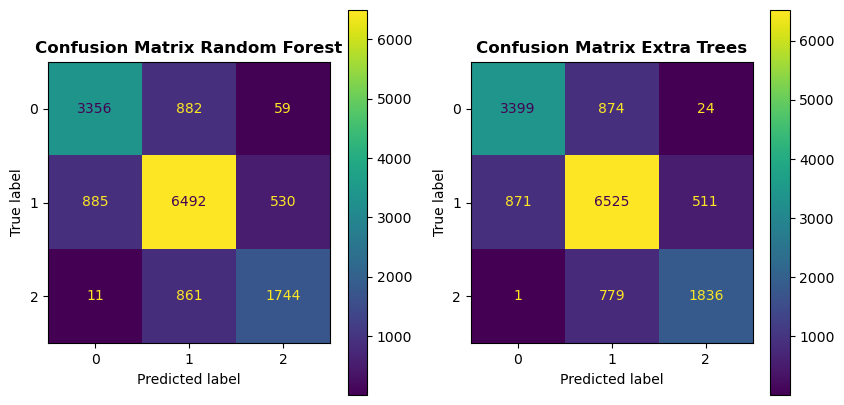

In [24]:
sk_models.plot_cm_models(figsize=(10,5))

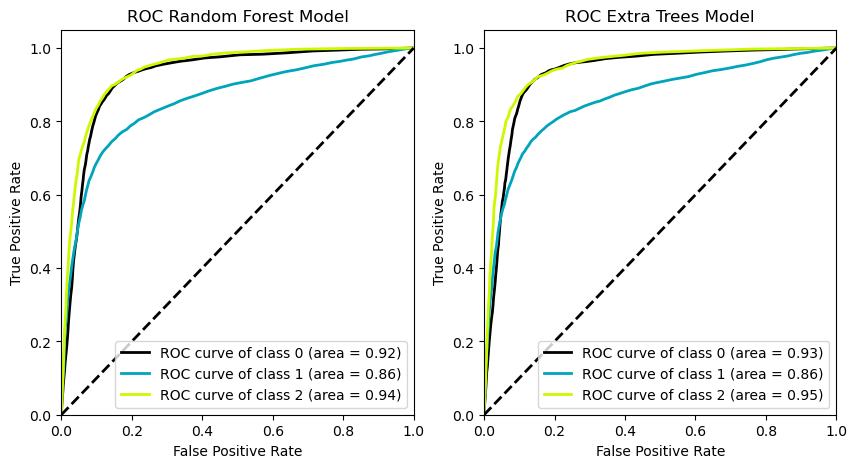

In [25]:
sk_models.plot_roc_auc_models(figsize=(10,5))

### Boosting Models

In [26]:
cat_model = CatBoostClassifier(loss_function='MultiClass',
                               eval_fraction=0.2,
                               eval_metric='HammingLoss', #Accuracy
                               early_stopping_rounds=100,
                               n_estimators=1000,
                               learning_rate=0.1,
                               depth=8,
                               verbose=100)
cat_model.fit(x_train_prep,y_train)

0:	learn: 0.3556141	test: 0.3700767	best: 0.3700767 (0)	total: 199ms	remaining: 3m 19s
100:	learn: 0.2781444	test: 0.3141604	best: 0.3140761 (98)	total: 6.16s	remaining: 54.8s
200:	learn: 0.2300053	test: 0.2915577	best: 0.2915577 (200)	total: 11.4s	remaining: 45.4s
300:	learn: 0.1952346	test: 0.2778949	best: 0.2778949 (300)	total: 15.9s	remaining: 37s
400:	learn: 0.1676753	test: 0.2688707	best: 0.2684490 (388)	total: 20.5s	remaining: 30.7s
500:	learn: 0.1467370	test: 0.2624610	best: 0.2620393 (482)	total: 25s	remaining: 24.9s
600:	learn: 0.1308593	test: 0.2565573	best: 0.2565573 (600)	total: 29.4s	remaining: 19.5s
700:	learn: 0.1182499	test: 0.2526777	best: 0.2524247 (692)	total: 33.8s	remaining: 14.4s
800:	learn: 0.1041012	test: 0.2504849	best: 0.2502319 (799)	total: 38.3s	remaining: 9.52s
900:	learn: 0.0907116	test: 0.2478705	best: 0.2468584 (899)	total: 42.8s	remaining: 4.7s
999:	learn: 0.0797681	test: 0.2474488	best: 0.2464367 (965)	total: 47.2s	remaining: 0us

bestTest = 0.2464367

In [28]:
xgb_model = xgboost.XGBClassifier(objective='multi:softprob',
                                  n_estimators=1000,
                                  early_stopping_rounds=100,
                                  eval_metric=['merror','mlogloss'])
xgb_model.fit(x_train_prep,y_train,
              eval_set=[(x_train_prep, y_train), (x_test_prep, y_test)],
              verbose=100)

[0]	validation_0-merror:0.32309	validation_0-mlogloss:0.95728	validation_1-merror:0.32767	validation_1-mlogloss:0.95955
[100]	validation_0-merror:0.16339	validation_0-mlogloss:0.46083	validation_1-merror:0.26059	validation_1-mlogloss:0.60932
[200]	validation_0-merror:0.10059	validation_0-mlogloss:0.34617	validation_1-merror:0.23860	validation_1-mlogloss:0.57510
[300]	validation_0-merror:0.06302	validation_0-mlogloss:0.26719	validation_1-merror:0.23050	validation_1-mlogloss:0.55477
[400]	validation_0-merror:0.03762	validation_0-mlogloss:0.20824	validation_1-merror:0.22544	validation_1-mlogloss:0.54656
[500]	validation_0-merror:0.02012	validation_0-mlogloss:0.16507	validation_1-merror:0.22503	validation_1-mlogloss:0.54449
[600]	validation_0-merror:0.01059	validation_0-mlogloss:0.13279	validation_1-merror:0.22355	validation_1-mlogloss:0.54451
[700]	validation_0-merror:0.00476	validation_0-mlogloss:0.10623	validation_1-merror:0.22321	validation_1-mlogloss:0.54794
[719]	validation_0-merror:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [29]:
boosting_models = AnalyzingModelPerformance(x_test_prep,
                                            y_test,
                                            models=[cat_model,xgb_model],
                                            names=['catboost','xgboost'])
cat_report, xgb_report  = boosting_models.models_reports()

In [30]:
print(cat_report, xgb_report)

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      4297
           1       0.76      0.81      0.78      7907
           2       0.71      0.62      0.66      2616

    accuracy                           0.75     14820
   macro avg       0.75      0.72      0.73     14820
weighted avg       0.75      0.75      0.75     14820
               precision    recall  f1-score   support

           0       0.78      0.77      0.77      4297
           1       0.78      0.82      0.80      7907
           2       0.75      0.67      0.71      2616

    accuracy                           0.78     14820
   macro avg       0.77      0.75      0.76     14820
weighted avg       0.78      0.78      0.78     14820



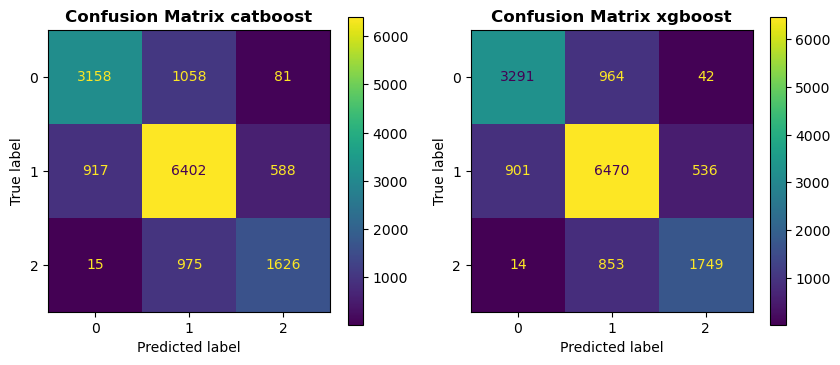

In [31]:
boosting_models.plot_cm_models(figsize=(10,4))

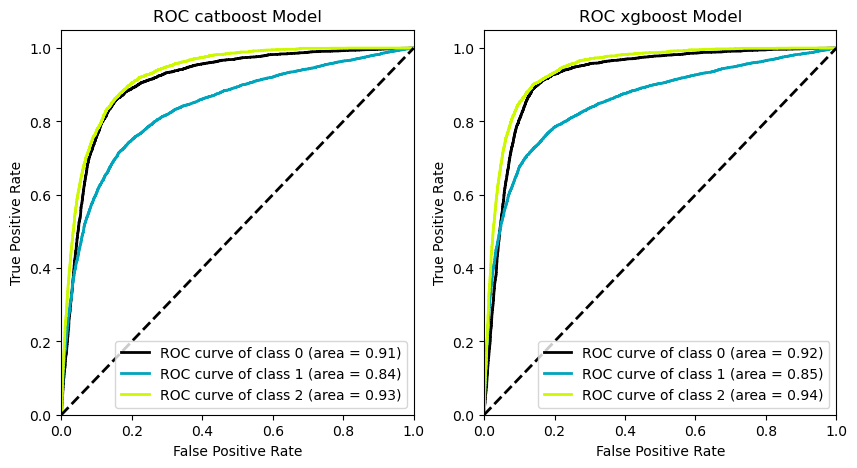

In [32]:
boosting_models.plot_roc_auc_models(figsize=(10,5))

### Cross Validation with models in validation data

In [34]:
cross_val_unb = {}

xgb = xgboost.XGBClassifier(objective='multi:softprob',
                                  n_estimators=1000,
                                  early_stopping_rounds=100,
                                  eval_metric=['merror','mlogloss'])
cat =  CatBoostClassifier(loss_function='MultiClass',
                               eval_fraction=0.2,
                               eval_metric='HammingLoss', #Accuracy
                               early_stopping_rounds=100,
                               n_estimators=1000,
                               learning_rate=0.1,
                               depth=8,
                               verbose=False)

rnd = RandomForestClassifier()
et = ExtraTreesClassifier()

for name, model in zip(['xgb',"catboost",'random-forest','extra-trees'],
                       [xgb,cat,
                        rnd,et]):
    
    if name == 'xgb':
        cross_val_unb[name] = cross_val_score(estimator=model,
                                            X=x_train_prep,
                                            y=y_train,
                                            cv=10,
                                            params={'eval_set':[(x_train_prep, y_train), (x_test_prep, y_test)],
                                                    'verbose':False})

    else:
        cross_val_unb[name] = cross_val_score(estimator=model,
                                            X=x_train_prep,
                                            y=y_train,
                                            cv=10)

In [35]:
cross_val_results = pd.DataFrame(cross_val_unb)

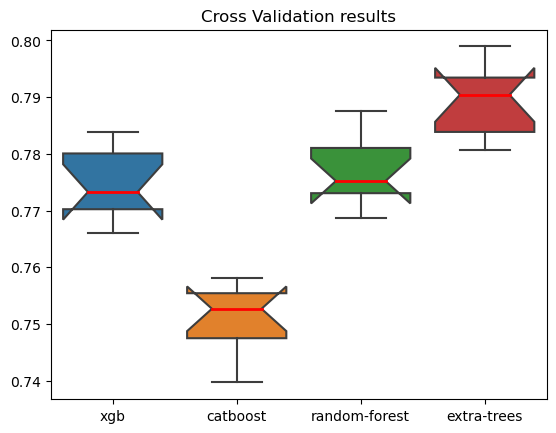

In [36]:
sns.boxplot(data=cross_val_results,
            medianprops={"color": "r", "linewidth": 2},
            notch=True)
plt.title('Cross Validation results')
plt.show()

In [37]:
cross_val_results

,xgb,catboost,random-forest,extra-trees
0,0.783907,0.753374,0.782389,0.797908
1,0.770243,0.752024,0.773954,0.784244
2,0.770243,0.739710,0.768725,0.780702
3,0.772773,0.744939,0.772942,0.783738
4,0.766532,0.749157,0.770412,0.792173
5,0.766026,0.746964,0.773448,0.782557
6,0.780364,0.758097,0.781208,0.793860
7,0.781883,0.755567,0.780533,0.798920
8,0.773785,0.755061,0.776484,0.788630
9,0.779184,0.757760,0.787618,0.792173


### Hyperparameter tuning

In [52]:
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [40]:
# Optimize in validation set
x_train,x_val, y_train, y_val = train_test_split(x_train_prep,y_train, train_size=0.80, random_state=42)


In [49]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators',80,1000)
    criterion = trial.suggest_categorical('criterion', choices=['gini','entropy','log_loss'])
    bootstrap = trial.suggest_categorical('bootstrap', choices=[True, False])

    
    final_model = ExtraTreesClassifier(n_estimators=n_estimators,
                                       max_depth=None,
                                       criterion=criterion,
                                       bootstrap=bootstrap,
                                       n_jobs=4)
    final_model.fit(x_train,y_train)
    
    preds = final_model.predict(x_val)
    f1 = f1_score(y_val,preds,
                  average='micro')
    
    return f1

study = optuna.study.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=50)

best_paramas = study.best_params

[I 2024-03-25 18:32:57,684] A new study created in memory with name: no-name-8b3a3e43-715c-4a71-bc77-37fefa303e21
[I 2024-03-25 18:33:05,351] Trial 0 finished with value: 0.7812921727395412 and parameters: {'n_estimators': 415, 'criterion': 'log_loss', 'bootstrap': False}. Best is trial 0 with value: 0.7812921727395412.
[I 2024-03-25 18:33:19,348] Trial 1 finished with value: 0.7816295546558705 and parameters: {'n_estimators': 761, 'criterion': 'log_loss', 'bootstrap': False}. Best is trial 1 with value: 0.7816295546558705.
[I 2024-03-25 18:33:27,620] Trial 2 finished with value: 0.7793522267206477 and parameters: {'n_estimators': 639, 'criterion': 'entropy', 'bootstrap': True}. Best is trial 1 with value: 0.7816295546558705.
[I 2024-03-25 18:33:34,330] Trial 3 finished with value: 0.7787618083670715 and parameters: {'n_estimators': 525, 'criterion': 'log_loss', 'bootstrap': True}. Best is trial 1 with value: 0.7816295546558705.
[I 2024-03-25 18:33:46,482] Trial 4 finished with value: 

In [51]:
final_model = ExtraTreesClassifier(**best_paramas,
                                   n_jobs=4)
final_model.fit(x_train, y_train)

ExtraTreesClassifier(n_estimators=281, n_jobs=4)

### Final Model Report

In [53]:
preds = final_model.predict(x_test_prep)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      4297
           1       0.79      0.82      0.81      7907
           2       0.76      0.70      0.73      2616

    accuracy                           0.79     14820
   macro avg       0.78      0.77      0.77     14820
weighted avg       0.79      0.79      0.79     14820



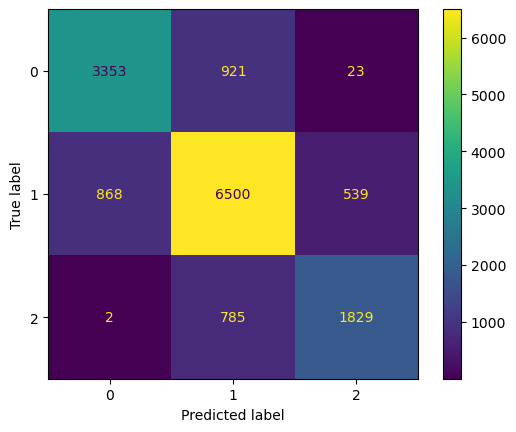

In [55]:
cm_final = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm_final).plot()
plt.show()

### Export Pipeline model

In [56]:
import joblib
from sklearn.pipeline import Pipeline

In [57]:
model_pipeline = Pipeline([('preprocesing', col_prepro),
                           ('model', final_model)])

In [58]:
new_instance = pd.DataFrame(X.iloc[3]).T

In [65]:
joblib.dump(model_pipeline, '../model.pkl')

['../model.pkl']